In [ ]:
import keras.models
!pip install sklearn tensorflow

In [1]:
import numpy as np
import os
import constants as cs
import yaml
import globali as gg
import datetime

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

### Load configuration data

In [3]:
def read_yaml_fields():
    with open(cs.YAMLFILE, 'r') as ff:
        content = yaml.safe_load(ff)
        a = set(content.get('actions', []))
        c = content.get('counter', {})
        return a, c

# Load actions and counters
gg.actions, gg.counters = read_yaml_fields()

In [4]:
# display(len(gg.actions))
# display(gg.actions)
# display(gg.counters)
label_map = {label:num for num, label in enumerate(gg.actions)}
len(label_map)

27

### Read keypoints and split train and test set

In [5]:
sequences, labels = [], []

# get all the keypoints
for action in tqdm(gg.actions, desc="Processing Actions"):
    for sequence in range(gg.counters[action]):
        window = []
        for frame_num in range(cs.NUM_FRAME):
            res = np.load(os.path.join(cs.KEYPOINTS_FOLDER, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])


Processing Actions: 100%|██████████| 27/27 [00:50<00:00,  1.88s/it]


In [6]:
print(np.array(sequences).shape)       # 15 videos, 30 frames, 1662 features
print(np.array(labels).shape)
print(labels)

(2700, 30, 1662)
(2700,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [7]:
X = np.array(sequences)
X.shape

(2700, 30, 1662)

In [8]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
print(y_train.shape)
print(y_test.shape)

(2565, 27)
(135, 27)


### Build and Train LSTM Natural Network

In [17]:
def create_folder_for_training(number):
    # create folders
    log_f = os.path.join(cs.LOGS_FOLDER, 'log_' + str(number), '')
    # log_f = os.path.join(os.getcwd(), 'logs')
    #log_f = ""
    # log_f = cs.LOGS_FOLDER + "" + "log_" + str(number)
    model_f = os.path.join(cs.MODELS_FOLDER, 'model_' + str(number))
    # train_f = os.path.join(cs.TRAINING_FOLDER, 'training_' + str(number))
    os.makedirs(log_f, exist_ok=True)
    os.makedirs(model_f, exist_ok=True)
    log_f = "D:\logs" # + "log_" + str(number)
    return log_f, model_f

In [42]:
os.getcwd()

'D:\\Università\\Magistrale_Roma_Tre\\Deep_Learning\\Progetto\\PROGETTO\\AslDetenction'

In [18]:
log_f, model_f = create_folder_for_training(0)

In [19]:
# log
tensorboard_callback = TensorBoard(log_dir=log_f, histogram_freq=1)
training_log = os.path.join(log_f, 'train_log.csv')
csv_logger = CSVLogger(training_log, append=True)

In [13]:
# LSTM
np_actions = np.array(list(gg.actions))
print(np_actions.shape[0])
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(np_actions.shape[0], activation='softmax'))


27


In [32]:
# LOAD MODEL

# del model
model = Sequential()
model = model.load_weights('./models/old/final_model.h5')


ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

In [20]:
# GRU

np_actions = np.array(list(gg.actions))
print(np_actions.shape[0])
model = Sequential()
model.add(GRU(64, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(Dropout(0.2))
model.add(GRU(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(np_actions.shape[0], activation='softmax'))


27


In [23]:
# TRANSFORMERS


In [70]:
# Old LSTM

np_actions = np.array(list(gg.actions))
print(np_actions.shape[0])
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(np_actions.shape[0], activation='softmax'))

27


In [21]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
best_model_path = os.path.join(model_f, 'best_model.h5') 
checkpoint = ModelCheckpoint(best_model_path, monitor='loss', save_best_only=True)
history = model.fit(X_train, y_train, epochs=3000, callbacks=[early_stopping,
                                                              checkpoint,
                                                              csv_logger,
                                                              tensorboard_callback])
# save best model
final_model_path = os.path.join(model_f, 'final_model.h5')
model.save(final_model_path)

Epoch 1/3000
81/81 [==============================] - 19s 90ms/step - loss: 4.5323 - categorical_accuracy: 0.0394
Epoch 2/3000
81/81 [==============================] - 9s 106ms/step - loss: 4.1371 - categorical_accuracy: 0.0398
Epoch 3/3000
81/81 [==============================] - 9s 113ms/step - loss: 3.9415 - categorical_accuracy: 0.0480
Epoch 4/3000
81/81 [==============================] - 7s 88ms/step - loss: 3.7511 - categorical_accuracy: 0.0717
Epoch 5/3000
81/81 [==============================] - 7s 85ms/step - loss: 3.6033 - categorical_accuracy: 0.0749
Epoch 6/3000
81/81 [==============================] - 7s 84ms/step - loss: 3.4854 - categorical_accuracy: 0.0877
Epoch 7/3000
81/81 [==============================] - 7s 83ms/step - loss: 3.3270 - categorical_accuracy: 0.0967
Epoch 8/3000
81/81 [==============================] - 7s 83ms/step - loss: 3.2332 - categorical_accuracy: 0.0967
Epoch 9/3000
81/81 [==============================] - 7s 81ms/step - loss: 3.1610 - categoric

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 30, 64)            331776    
                                                                 
 dropout_4 (Dropout)         (None, 30, 64)            0         
                                                                 
 gru_4 (GRU)                 (None, 30, 128)           74496     
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                      

In [23]:
def write_layers(s):
    with open('./models/model_0/layers.txt', 'a') as f:
        print(s, file=f)

model.summary(print_fn=write_layers)

### Make Predictions

In [24]:
res = model.predict(X_test)

5/5 [==============================] - 4s 23ms/step


In [25]:
np_actions[np.argmax(res[4])]

'm'

In [26]:
np_actions[np.argmax(y_test[4])]

'm'

In [38]:
# model.load_weights('action.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'action.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Evaluation using Confusion Matrix and Accuracy

In [34]:
# Caricare il modello salvato
# loaded_model = keras.models.load_model('models/best_model.h5')

In [27]:
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 22ms/step


In [28]:
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()


In [29]:
len(y_true)

135

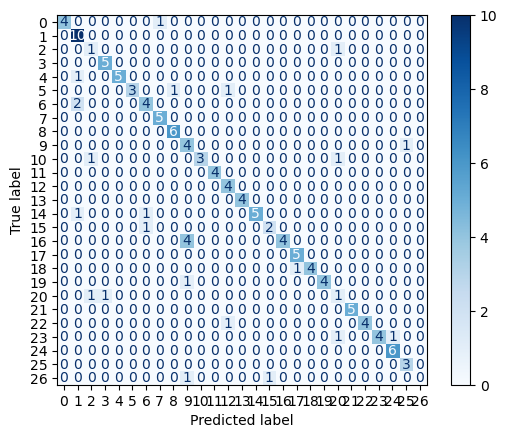

In [30]:
# CONFUSION MATRIX 

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# Personalizzare il plot con una scala di blu
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap='Blues')
plt.show()


In [31]:
accuracy_score(y_true, y_pred)

0.8074074074074075